In [2]:
import pandas
import librosa
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy.ndimage import zoom
import os
from scipy.signal import butter, filtfilt

In [5]:
SAMPLING_RATE = 16000
DATASET_PATH = "./dataset/"
CRACK_MELS_FILENAME = "./dataset/crack/mels.npy"
NO_CRACK_MELS_FILENAME = "./dataset/no_crack/mels.npy"

In [3]:
def low_cut_filter(data, cutoff_freq, sample_rate, order=5):
    # Design a Butterworth low-cut filter
    nyquist = 0.5 * sample_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    
    # Apply the filter to the data
    filtered_data = filtfilt(b, a, data)
    return filtered_data

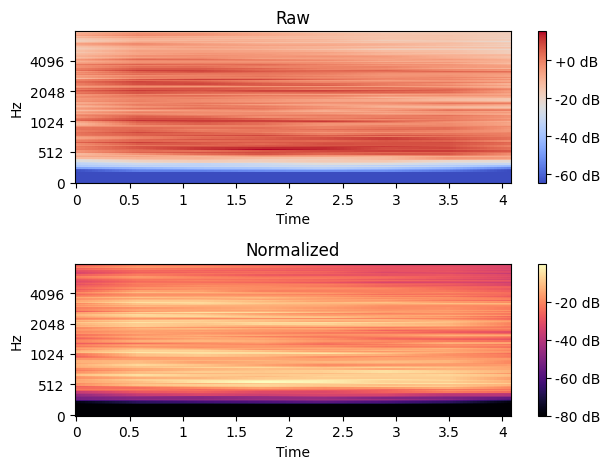

In [9]:
def convert_to_log_scale(spectro):
    # Convert to log scale
    log_spectro = librosa.power_to_db(spectro)

    log_spectro = zoom(log_spectro, (128/log_spectro.shape[0], 128/log_spectro.shape[1]), order=1)  # SciPy

    return log_spectro

# Load an audio file
audio, sr = librosa.load('./dataset/crack/crack.00000.wav', sr=SAMPLING_RATE)

audio = low_cut_filter(data=audio, cutoff_freq=500.0, sample_rate=sr)

# Convert audio to Mel-spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)

# Convert to log scale
log_mel_spectrogram = convert_to_log_scale(mel_spectrogram)

# Normalized version
S = mel_spectrogram
S_min = S.min()
S_max = S.max()

mel_spectrogram_normalized = (S - S_min) / (S_max - S_min)

log_mel_spectrogram_normalized = convert_to_log_scale(mel_spectrogram_normalized)

# Plot the first Mel-spectrogram
plt.subplot(2, 1, 1)  # 2 rows, 1 column, position 1
librosa.display.specshow(log_mel_spectrogram, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Raw')

# Plot the second Mel-spectrogram
plt.subplot(2, 1, 2)  # 2 rows, 1 column, position 2
librosa.display.specshow(log_mel_spectrogram_normalized, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Normalized')

# Display the plots
plt.tight_layout()
plt.show()

In [11]:
def preprocess_wav(filepath):
    # Load an audio file
    audio, sr = librosa.load(filepath, sr=SAMPLING_RATE)
    audio = low_cut_filter(data=audio, cutoff_freq=500.0, sample_rate=sr)


    # Convert audio to Mel-spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)

    # Normalized version
    S = mel_spectrogram
    S_min = S.min()
    S_max = S.max()

    mel_spectrogram = (S - S_min) / (S_max - S_min)

    # Convert to log scale
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

    log_mel_spectrogram = zoom(log_mel_spectrogram, (128/log_mel_spectrogram.shape[0], 128/log_mel_spectrogram.shape[1]), order=1)  # SciPy
    # Normalize and reshape the data
    # log_mel_spectrogram = log_mel_spectrogram / np.max(log_mel_spectrogram)

    log_mel_spectrogram = np.expand_dims(log_mel_spectrogram, axis=-1)  # Add channel dimension
    # log_mel_spectrogram = np.expand_dims(log_mel_spectrogram, axis=0)   # Add batch dimension

    return log_mel_spectrogram

In [12]:
# store mels
crack_mels = []

# loop through folders
for i, (dirpath, dirnames, filenames) in enumerate(os.walk(DATASET_PATH + '/crack')):
    for fname in filenames:
        if(fname.find('.wav') < 0) :
           continue
        path = DATASET_PATH + '/crack/' + fname
        log_mel_spectogram = preprocess_wav(path)  
        crack_mels.append(log_mel_spectogram)

In [13]:
# Save to a NumPy binary file
np_crack_mels = np.array(crack_mels)
np.save(CRACK_MELS_FILENAME, np_crack_mels)

In [14]:
print(len(np_crack_mels))

17


In [15]:
# Create traffic noise dataset

filepath = './dataset/no_crack/roast1_no_crack.wav'
segment_duration = 0.2 #seconds
segment_count_total = 17

# Load an audio file
audio, sr = librosa.load(filepath, sr=SAMPLING_RATE)
audio = low_cut_filter(data=audio, cutoff_freq=500.0, sample_rate=sr)

# Calculate samples per segment
samples_per_segment = int(segment_duration * sr)

# Split audio into segments
segments = []
for start in range(0, len(audio), samples_per_segment):
    end = start + samples_per_segment
    segment = audio[start:end]
    segments.append(segment)

    print(f"processing segment-{len(segments)}")

    if(len(segments) >= segment_count_total) :
        break

segment_mels = []

for idx, segment in enumerate(segments):
    # Convert audio to Mel-spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=128, fmax=8000)

    # Normalized version
    S = mel_spectrogram
    S_min = S.min()
    S_max = S.max()

    mel_spectrogram = (S - S_min) / (S_max - S_min)
    
    # Convert to log scale
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

    log_mel_spectrogram = zoom(log_mel_spectrogram, (128/log_mel_spectrogram.shape[0], 128/log_mel_spectrogram.shape[1]), order=1)  # SciPy

    log_mel_spectrogram = np.expand_dims(log_mel_spectrogram, axis=-1)  # Add channel dimension
    print(np.array(log_mel_spectrogram).shape)
    
    segment_mels.append(log_mel_spectrogram)
# Save to a NumPy binary file
np_traffic_noises = np.array(segment_mels)
np.save(NO_CRACK_MELS_FILENAME, np_traffic_noises)

processing segment-1
processing segment-2
processing segment-3
processing segment-4
processing segment-5
processing segment-6
processing segment-7
processing segment-8
processing segment-9
processing segment-10
processing segment-11
processing segment-12
processing segment-13
processing segment-14
processing segment-15
processing segment-16
processing segment-17
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
